# 01 - Intro to Natural Language Processing
* What is NLP?
* Some examples:
  * Part-of-speech tagging: identify if each word is a noun, verb, adjective, etc.)
  * Named entity recognition NER): identify person names, organizations, locations, medical codes, time expressions, quantities, monetary values, etc)
  * Question answering
  * Speech recognition
  * Text-to-speech and Speech-to-text
  * Topic modeling
  * Sentiment classification
  * Language modeling
  * Translation
  
* Some caviates: 
  * Can and will take longer to train
  * The fastai has made some improvements, but expect 1-2 hrs on real datasets, if not longer

# What will we be doing today?

## IMDB
* Sentement analysis of movie reviews and rating if something was good or bad

In [0]:
!pip install git+https://github.com/fastai/fastai2.git -q
!pip install git+https://github.com/fastai/fastcore.git -q

In [0]:
from fastai2.text.all import *

# Data Preparation

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

Our sample just has one file, let's take a look

In [0]:
df = pd.read_csv(f'{path}/texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

# Pipeline

For NLP tasks, we have a bit of a different pipeline. We will train two models, a language model which will act as our embeddings, and a classifier on top. The model itself is called ULM-FiT.

Language model: We will train on our entire corpus's language (subject), usually pretrained on your language of choice (English, Spanish, etc.)

Classifier: We load in our initial language model and pop on a classifier on top.

Our csv contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataLoaders.from_csv(path, 'texts.csv', text_col='text', is_lm=True)

In [0]:
data_lm.show_batch()

,text,text_
0,"xxbos xxmaj john xxmaj xxunk 's "" deliverance "" concerns four xxunk xxmaj atlanta xxunk who take a ride down the swift waters of the xxmaj xxunk ▁ xxmaj the river is about to disappear for a xxunk construction and the xxunk of the last xxunk xxunk of land xxunk xxmaj the four friends emphasize different characters : a xxunk sports xxunk who has never been xxunk in his life since there","xxmaj john xxmaj xxunk 's "" deliverance "" concerns four xxunk xxmaj atlanta xxunk who take a ride down the swift waters of the xxmaj xxunk ▁ xxmaj the river is about to disappear for a xxunk construction and the xxunk of the last xxunk xxunk of land xxunk xxmaj the four friends emphasize different characters : a xxunk sports xxunk who has never been xxunk in his life since there is"
1,"like real bugs . xxmaj it 's like the team that made the movie found a way to bring us into the mind of a child and allow us to think like them , to imagine bugs the way a young mind does . \n\n xxmaj xxunk , i xxmaj xxunk xxmaj the xxmaj kids was one of my favorite films when i was younger , and to me , a xxmaj","real bugs . xxmaj it 's like the team that made the movie found a way to bring us into the mind of a child and allow us to think like them , to imagine bugs the way a young mind does . \n\n xxmaj xxunk , i xxmaj xxunk xxmaj the xxmaj kids was one of my favorite films when i was younger , and to me , a xxmaj bug"
2,"n't all that hard to do anyway ) , slightly that is . xxmaj you know you have a problem when some of the suitors are actually hotter and more interesting than the leading man . xxmaj and the fact that the suitors seem to have more fun around xxup each xxup other than with the leading man ? xxmaj very sad . \n\n xxmaj also , i just thought that xxmaj","all that hard to do anyway ) , slightly that is . xxmaj you know you have a problem when some of the suitors are actually hotter and more interesting than the leading man . xxmaj and the fact that the suitors seem to have more fun around xxup each xxup other than with the leading man ? xxmaj very sad . \n\n xxmaj also , i just thought that xxmaj i"
3,"age , this particular film suffers because xxmaj fox xxmaj studios oddly cast them in a supporting role and created a parallel plot involving a young couple -- something that reduced their time on screen xxup and turned them into insipid "" xxunk on "" instead of just being themselves . a cute and xxunk xxmaj stan and xxmaj ollie is very foreign to the old xxmaj laurel and xxmaj hardy of",", this particular film suffers because xxmaj fox xxmaj studios oddly cast them in a supporting role and created a parallel plot involving a young couple -- something that reduced their time on screen xxup and turned them into insipid "" xxunk on "" instead of just being themselves . a cute and xxunk xxmaj stan and xxmaj ollie is very foreign to the old xxmaj laurel and xxmaj hardy of the"
4,"so . xxmaj in fact , the plot is constructed in such a way so that the girl gets no one . \n\n xxmaj there is an early scene where xxmaj johansson , for no reason central to the movie , allows herself to be gotten drunk , and seduced , by a powerful , older director . "" seduced "" is a xxunk for what happens . xxmaj it 's a",". xxmaj in fact , the plot is constructed in such a way so that the girl gets no one . \n\n xxmaj there is an early scene where xxmaj johansson , for no reason central to the movie , allows herself to be gotten drunk , and seduced , by a powerful , older director . "" seduced "" is a xxunk for what happens . xxmaj it 's a """
5,"also , instead of simply showing racism for the ugly and stupid thing it is , xxmaj spike xxmaj lee chooses to wave it around like a flag in a most xxunk and irritating manner . i made it through most of the film but i could n't quite finish it , and that , for me , rarely happens . xxbos xxmaj plot = xxmaj melissa is a new girl in",", instead of simply showing racism for the ugly and stupid thing it is , xxma

# Tokenizing

First step is to take our texts, and split the raw sentences into tokens to take care of either special phrases or characters. 

Here are some processes we need to take care of:
* Punctuation
* Contractions (isn't, don't)
* HTML code, etc

In [0]:
data_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj this has got to be one of my very favorite xxmaj twilight xxmaj zone episodes , primarily for the portrayal of two lonely souls in a post - xxunk environment . \n\n xxmaj the xxunk - xxunk shops and xxunk - xxunk streets are eerie in that particular way the xxmaj twilight xxmaj zone does best . \n\n xxmaj while the parable can be a bit heavy - handed by","xxmaj this has got to be one of my very favorite xxmaj twilight xxmaj zone episodes , primarily for the portrayal of two lonely souls in a post - xxunk environment . \n\n xxmaj the xxunk - xxunk shops and xxunk - xxunk streets are eerie in that particular way the xxmaj twilight xxmaj zone does best . \n\n xxmaj while the parable can be a bit heavy - handed by today"
1,", this touching moment is played out in a very sad way in the finale of the movie . \n\n xxmaj xxunk xxmaj xxunk and xxmaj xxunk ' joe ' xxmaj xxunk are outstanding as xxmaj noam and xxmaj ashwar . xxmaj director xxmaj xxunk xxmaj fox is brilliant in creating a xxunk and interesting xxunk of the xxmaj shakespeare classic xxmaj xxunk and xxmaj xxunk . xxmaj and while most movies",this touching moment is played out in a very sad way in the finale of the movie . \n\n xxmaj xxunk xxmaj xxunk and xxmaj xxunk ' joe ' xxmaj xxunk are outstanding as xxmaj noam and xxmaj ashwar . xxmaj director xxmaj xxunk xxmaj fox is brilliant in creating a xxunk and interesting xxunk of the xxmaj shakespeare classic xxmaj xxunk and xxmaj xxunk . xxmaj and while most movies today
2,"each other xxunk far beyond the xxunk of mere xxunk . xxmaj their 's is a true and abiding friendship for one another and each would be willing to sacrifice his own life for the good of the other . xxmaj gunga xxmaj din xxunk to be a soldier too , a xxmaj xxunk in particular , but can never xxunk that rank due to his xxunk social standing . xxmaj however","other xxunk far beyond the xxunk of mere xxunk . xxmaj their 's is a true and abiding friendship for one another and each would be willing to sacrifice his own life for the good of the other . xxmaj gunga xxmaj din xxunk to be a soldier too , a xxmaj xxunk in particular , but can never xxunk that rank due to his xxunk social standing . xxmaj however ,"


The texts are truncated at 100 tokens for readability. Here are some other things we did using Spacy

* 's' are grouped together
* contractions are seperated like so "did", "n't"
* Any HTML symbol has been cleaned
* Everything is lower-cased
* there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields

# Numericalization

Once we have our tokens, we can convert them to integers. These are then saved in a `vocab`, in a dictionary called `itos` (int to string)

In [0]:
data_lm.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [0]:
data_lm.numericalize

Numericalize: (object,object) -> encodes (object,object) -> decodes

# Spacy

We use spacy as the main way to actually tokenize. [See here](https://spacy.io/)

In [0]:
data_lm.tokenizer

(#2) [<fastai2.text.core.SpacyTokenizer object at 0x7fec92ef55f8>,Tokenizer: (str,object) -> encodes
(Path,object) -> encodes (object,object) -> decodes]

In [0]:
data_lm.rules

[<function fastai2.text.core.fix_html>,
 <function fastai2.text.core.replace_rep>,
 <function fastai2.text.core.replace_wrep>,
 <function fastai2.text.core.spec_add_spaces>,
 <function fastai2.text.core.rm_useless_spaces>,
 <function fastai2.text.core.replace_all_caps>,
 <function fastai2.text.core.replace_maj>,
 <function fastai2.text.core.lowercase>]

Well that's quite unreadable. Let's write a quick function to make that a bit better:


In [0]:
def print_rules(dls):
  "Prints out current rules of `Tokenizer`"
  print(f"{dls.tokenizer[0].__doc__} with the following rules\n")
  [print(f"{r.__name__, r.__doc__}") for r in dls.rules]

In [0]:
print_rules(data_lm)

Spacy tokenizer for `lang` with the following rules

('fix_html', "Various messy things we've seen in documents")
('replace_rep', 'Replace repetitions at the character level: cccc -- TK_REP 4 c')
('replace_wrep', 'Replace word repetitions: word word word word -- TK_WREP 4 word')
('spec_add_spaces', 'Add spaces around / and #')
('rm_useless_spaces', 'Remove multiple spaces')
('replace_all_caps', 'Replace tokens in ALL CAPS by their lower version and add `TK_UP` before.')
('replace_maj', 'Replace tokens in ALL CAPS by their lower version and add `TK_UP` before.')
('lowercase', 'Converts `t` to lowercase')


In [0]:
data_lm.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [0]:
data_lm.o2i.items()

dict_items([('xxunk', 0), ('xxpad', 1), ('xxbos', 2), ('xxeos', 3), ('xxfld', 4), ('xxrep', 5), ('xxwrep', 6), ('xxup', 7), ('xxmaj', 8), ('the', 9), (',', 10), ('.', 11), ('and', 12), ('a', 13), ('of', 14), ('to', 15), ('is', 16), ('it', 17), ('in', 18), ('i', 19), ('that', 20), ('this', 21), ('"', 22), ("'s", 23), ('-', 24), ('was', 25), ('\n\n', 26), ('as', 27), ('for', 28), ('movie', 29), ('with', 30), ('but', 31), ('film', 32), ('you', 33), (')', 34), ('on', 35), ('(', 36), ("n't", 37), ('are', 38), ('not', 39), ('he', 40), ('his', 41), ('have', 42), ('be', 43), ('one', 44), ('they', 45), ('all', 46), ('at', 47), ('by', 48), ('an', 49), ('like', 50), ('from', 51), ('so', 52), ('who', 53), ('!', 54), ('there', 55), ('about', 56), ('or', 57), ('just', 58), ('if', 59), ('out', 60), ('do', 61), ('her', 62), ('some', 63), ('what', 64), ("'", 65), ('has', 66), ('more', 67), ('good', 68), ('?', 69), ('very', 70), ('up', 71), ('when', 72), ('she', 73), ('would', 74), ('no', 75), ('were', 

# Full Datablock API

Now let's use the `DataBlock` API to build it again:

In [0]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter(0.1))

Since we have no targets, we just need one block. Each `TextBlock` has a specific class method (either `from_folder` or `from_df`). This is so we can tokenize efficiently. We can then make our `DataLoaders`:

In [0]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)

In [0]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos i watched this movie with some friends a couple months ago , i still laugh today thinking about some of the utter stupidity . xxmaj the first few scenes alone were hilarious . i wo n't spoil anything for those who wish to see it , i would n't want to ruin the laughs . xxmaj needless to say the entire time i watched this movie i was trying to figure","i watched this movie with some friends a couple months ago , i still laugh today thinking about some of the utter stupidity . xxmaj the first few scenes alone were hilarious . i wo n't spoil anything for those who wish to see it , i would n't want to ruin the laughs . xxmaj needless to say the entire time i watched this movie i was trying to figure out"
1,"soul xxunk , it is , instead , xxunk xxunk . \n\n xxmaj half - naked , father and son xxunk and xxunk to each other like lovers . "" homo - erotic "" is the point , loud and clear . xxup ok , so what ? \n\n xxmaj repeated more than once by the son is the line , supposedly lifted from "" lives of the xxmaj xxunk , ""","xxunk , it is , instead , xxunk xxunk . \n\n xxmaj half - naked , father and son xxunk and xxunk to each other like lovers . "" homo - erotic "" is the point , loud and clear . xxup ok , so what ? \n\n xxmaj repeated more than once by the son is the line , supposedly lifted from "" lives of the xxmaj xxunk , "" """
2,"rest of his life , the only problem being that the letter is n't signed . xxmaj so xxmaj leon needs to track down all the women he 's been with to find the woman of his dreams . xxmaj but sometimes , as xxmaj billy xxmaj dee xxmaj williams says in the film , the woman of your dreams is standing right in front of you . xxmaj there is also","of his life , the only problem being that the letter is n't signed . xxmaj so xxmaj leon needs to track down all the women he 's been with to find the woman of his dreams . xxmaj but sometimes , as xxmaj billy xxmaj dee xxmaj williams says in the film , the woman of your dreams is standing right in front of you . xxmaj there is also a"


But can we use another tokenizer? Sure! First let's install `SentencePiece`:

In [0]:
!pip install sentencepiece -q

Now we'll define a tokenizer function that wraps around `SentencePiece`

In [0]:
tok = SentencePieceTokenizer

And finally pass this into the `DataBlock`:

In [0]:
sp_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True, tok_func=tok),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter(0.1))

In [0]:
dls = sp_lm.dataloaders(df, bs=64, seq_len=72)

In [0]:
dls.show_batch(max_n=3)

,text,text_
0,"▁xxbos ▁xxmaj ▁we ' ve ▁all ▁been ▁there , ▁sitting ▁with ▁some ▁friends ▁watching ▁a ▁bad ▁movie , ▁laughing ▁at ▁how ▁terribl y ▁it ▁was ▁made ▁and ▁how ▁poor ▁the ▁acting ▁was ; ▁eventually ▁the ▁credits ▁roll ▁and ▁everyone ▁looks ▁around ▁and ▁says ▁"" how ▁is ▁it ▁possible ▁such ▁a ▁movie ▁was ▁made ? ▁who ▁paid ▁money ▁to ▁have ▁this ▁script ▁made ▁into ▁a ▁feature ▁film ?"" ▁xxmaj ▁well ▁xxmaj ▁jig s","▁xxmaj ▁we ' ve ▁all ▁been ▁there , ▁sitting ▁with ▁some ▁friends ▁watching ▁a ▁bad ▁movie , ▁laughing ▁at ▁how ▁terribl y ▁it ▁was ▁made ▁and ▁how ▁poor ▁the ▁acting ▁was ; ▁eventually ▁the ▁credits ▁roll ▁and ▁everyone ▁looks ▁around ▁and ▁says ▁"" how ▁is ▁it ▁possible ▁such ▁a ▁movie ▁was ▁made ? ▁who ▁paid ▁money ▁to ▁have ▁this ▁script ▁made ▁into ▁a ▁feature ▁film ?"" ▁xxmaj ▁well ▁xxmaj ▁jig s aw"
1,"ic es "" ▁( which ▁is ▁ quite ▁possibly ▁the ▁fun n est ▁bad ▁movie ▁ever ▁made ) ▁xxmaj ▁eye ▁xxmaj ▁candy : ▁xxmaj ▁ ka ri ▁xxmaj ▁rose ▁shows ▁xxup ▁ t & a ▁xxmaj ▁my ▁xxmaj ▁grade : ▁xxup ▁ d + ▁xxup ▁dvd ▁xxmaj ▁extras : ▁xxmaj ▁mere ly ▁a ▁theatrical ▁trailer ▁for ▁this ▁movie ▁xxbos ▁xxmaj ▁an ▁excellent ▁performance ▁by ▁xxmaj ▁a lix ▁xxmaj ▁ el ia s","es "" ▁( which ▁is ▁ quite ▁possibly ▁the ▁fun n est ▁bad ▁movie ▁ever ▁made ) ▁xxmaj ▁eye ▁xxmaj ▁candy : ▁xxmaj ▁ ka ri ▁xxmaj ▁rose ▁shows ▁xxup ▁ t & a ▁xxmaj ▁my ▁xxmaj ▁grade : ▁xxup ▁ d + ▁xxup ▁dvd ▁xxmaj ▁extras : ▁xxmaj ▁mere ly ▁a ▁theatrical ▁trailer ▁for ▁this ▁movie ▁xxbos ▁xxmaj ▁an ▁excellent ▁performance ▁by ▁xxmaj ▁a lix ▁xxmaj ▁ el ia s ▁highlights"
2,"▁away ▁more ▁about ▁the ▁plot ▁in ▁"" who ' s ▁xxmaj ▁got ▁xxmaj ▁the ▁xxmaj ▁gold "", ▁but ▁i ▁can ▁assure ▁that ▁it ▁is ▁as ▁cool ▁as ▁it ▁sounds . ▁xxmaj ▁the ▁supporting ▁performances ▁are ▁also ▁very ▁good , ▁and , ▁as ▁in ▁the ▁predecessors , ▁there ▁are ▁plenty ▁of ▁hilarious ly ▁ec centric ▁characters . ▁xxmaj ▁this ▁is ▁sadly ▁the ▁last ▁film ▁in ▁the ▁awesome ly ▁sleaz y ▁ ' hanzo","▁more ▁about ▁the ▁plot ▁in ▁"" who ' s ▁xxmaj ▁got ▁xxmaj ▁the ▁xxmaj ▁gold "", ▁but ▁i ▁can ▁assure ▁that ▁it ▁is ▁as ▁cool ▁as ▁it ▁sounds . ▁xxmaj ▁the ▁supporting ▁performances ▁are ▁also ▁very ▁good , ▁and , ▁as ▁in ▁the ▁predecessors , ▁there ▁are ▁plenty ▁of ▁hilarious ly ▁ec centric ▁characters . ▁xxmaj ▁this ▁is ▁sadly ▁the ▁last ▁film ▁in ▁the ▁awesome ly ▁sleaz y ▁ ' hanzo '"


# Training our Langage Model

Let's go back and use our Spacy tokenized databunch for this. I'm going to keep our dataset small, but idealy you should run this instead with the full IMDB dataset. I've included a method to run it at the bottom of this notebook. Our pretrained model for today will be wikitext-103, a model trained on English wikipedia articles. 

In [0]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)

In [0]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3)

Now let's use our good old friend `fastdot` and visualize this architecture:

In [0]:
pip install fastdot

In [0]:
from fastdot import *

### Hidden

In [0]:
inp = ['Input']
encoder = ['Embedding (7080,400)', 'Embedding Dropout']
rnn1 = ['LSTM (400, 1152)', 'RNN Dropout']
rnn2 = ['LSTM (1152, 1152)', 'RNN Dropout']
rnn3 = ['LSTM (1152, 400)', 'RNN Dropout']
dp = ['RNN Dropout']
dec = ['Linear (400, 7080)', 'RNN Dropout']

In [0]:
block1, block2, block3, block4, block5, block6 = ['Tokenized Input', 'Embeddings', 'RNN 1', 'RNN 2', 'RNN3',
                                          'Linear Decoder']

In [0]:
conns = ((block1, block2),
         (block2, block3),
         (block3, block4),
         (block4, block5),
         (block5, block6))

In [0]:
def color(o):
  if 'Embedding' in o : return 'white'
  if o == 'Input': return 'gray'
  if 'LSTM' in o: return 'coral'
  if 'RNN' in o: return 'lightblue'

In [0]:
node_defaults['fillcolor'] = color

In [0]:
model = [
         seq_cluster(inp, block1),
         seq_cluster(encoder, block2),
         seq_cluster(rnn1, block3),
         seq_cluster(rnn2, block4),
         seq_cluster(rnn3, block5),
         seq_cluster(dec, block6)

]

In [0]:
g = graph_items(*model)
g.add_items(*object_connections(conns))

(#5) [<pydot.Edge object at 0x7feb76905c88>,<pydot.Edge object at 0x7feb76905e10>,<pydot.Edge object at 0x7feb76905c18>,<pydot.Edge object at 0x7feb7695a240>,<pydot.Edge object at 0x7feb76905b00>]

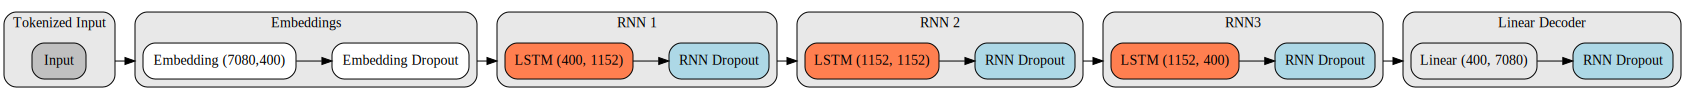

In [0]:
g

In [0]:
g.write_png('AWD_LSTM.png')

In [0]:
inp = ['Input']
encoder = ['Embedding (7080,400)', 'Embedding Dropout']
rnn1 = ['QRNN (400, 1152)', 'RNN Dropout']
rnn2 = ['QRNN (1152, 1152)', 'RNN Dropout']
rnn3 = ['QRNN (1152, 400)', 'RNN Dropout']
dp = ['RNN Dropout']
dec = ['Linear (400, 7080)', 'RNN Dropout']

In [0]:
def color(o):
  if 'Embedding' in o : return 'white'
  if o == 'Input': return 'gray'
  if 'QRNN ' in o: return 'coral'
  if 'RNN' in o: return 'lightblue'
  

In [0]:
node_defaults['fillcolor'] = color

In [0]:
model = [
         seq_cluster(inp, block1),
         seq_cluster(encoder, block2),
         seq_cluster(rnn1, block3),
         seq_cluster(rnn2, block4),
         seq_cluster(rnn3, block5),
         seq_cluster(dec, block6)

]

In [0]:
g = graph_items(*model)
g.add_items(*object_connections(conns))

(#5) [<pydot.Edge object at 0x7feb78f77160>,<pydot.Edge object at 0x7feb7694b9b0>,<pydot.Edge object at 0x7feb75557978>,<pydot.Edge object at 0x7feb7222a9b0>,<pydot.Edge object at 0x7feb71db74a8>]

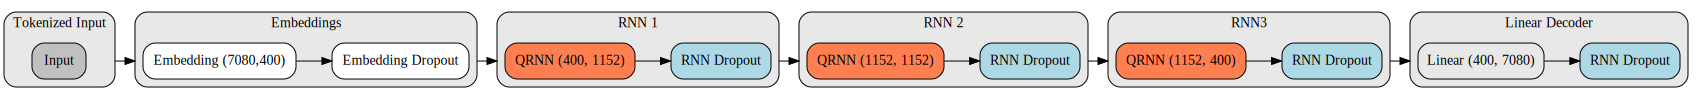

In [0]:
g

In [0]:
g.write_png('QRNN.png')

### Non-Hidden

In [0]:
from IPython.display import Image, display

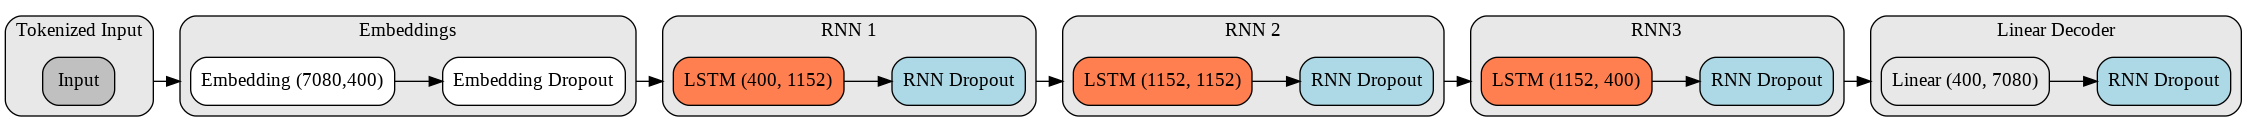

In [0]:
display(Image('AWD_LSTM.png'))

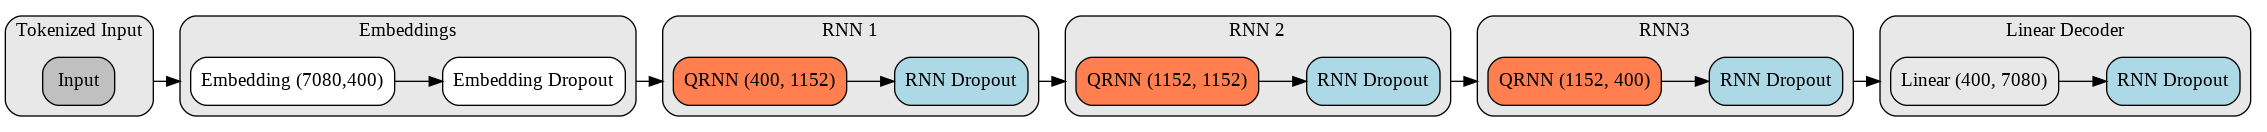

In [0]:
display(Image('QRNN.png'))

One thing we can also do to speed up training is to use something called Mixed Precision. To do this, we need everything in multiples of 8, hence our BS of 8. This helps use the CUDA cores (tensor cores) to the best of their ability

In [0]:
learn = learn.to_fp16()

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.033113110810518265)

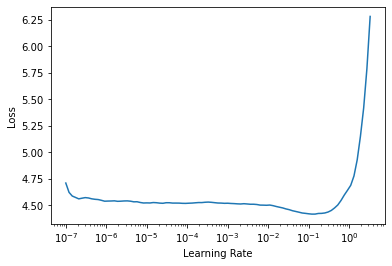

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,4.259218,4.049374,00:11


Now let's unfreeze and fit the rest

In [0]:
learn.unfreeze()

Ideally we should run this for 10 epochs or so, gradually unfreezing. However with our small sample we overfit very quickly

In [0]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,3.919846,3.921399,00:13


In [0]:
learn.save('fine_tuned')

How good is our model? Let's see

In [0]:
text = 'I liked this movie because'
n_words = 20
n_sentences=3

In [0]:
print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

i liked this movie because such characters are just walking out martial arts films , just that family which is not * driving or beating
i liked this movie because i have been younger changed since i 'm very bad in the film . i n't generally thought it was
i liked this movie because it ended up being on the list of TV shows in the United States . Creating


Seems like a movie review alright. Let's save our encoder and make our classifier

In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier

As I mentioned this is a transfer-learning approach to text classification. What's it look like? (Diagram based off of `fastai`'s)

### Hidden

In [0]:
encoder = ['WikiText 103']
lm = ['Corpus Text']
cls = ['Corpus Classification\nText']

In [0]:
block1, block2, block3 = ['Pre-Trained\nLanguage Model', 'Fine-Tuned\nLanguage Model', 'Classifier']
conns = ((block1, block2),
         (block2, block3))

In [0]:
def color(o):
  if 'WikiText' in o: return 'gray'
  if 'Classification' in o: return 'gold'
  else: return 'tan'
node_defaults['fillcolor'] = color

In [0]:
model = [
         seq_cluster(encoder, block1),
         seq_cluster(lm, block2),
         seq_cluster(cls, block3)

]

In [0]:
g = graph_items(*model)
g.add_items(*object_connections(conns))

(#2) [<pydot.Edge object at 0x7feb7691ce10>,<pydot.Edge object at 0x7feb76907a90>]

### Show

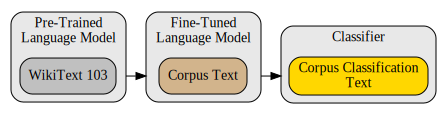

In [0]:
g

In [0]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [0]:
len(df)

1000

What's that `DataBlock` look like?

In [0]:
blocks = (TextBlock.from_df('text', seq_len=dls.seq_len, vocab=dls.vocab), CategoryBlock())

In [0]:
imdb_clas = DataBlock(blocks=blocks,
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter())

In [0]:
dls = imdb_clas.dataloaders(df, bs=64)

In [0]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present , almost diabolical",negative


Let's make our model and load our encoder in

In [0]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc');

In [0]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.820146,0.639425,0.730000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.580010,0.598723,0.710000,00:07
1,0.503913,0.477057,0.825000,00:07
2,0.460018,0.447098,0.800000,00:08
3,0.413971,0.397346,0.840000,00:07
4,0.387678,0.403905,0.835000,00:07


If we train on the entire dataset, we can achieve ~94%. I'll show the code to do that below

In [0]:
learn.predict("I really loved that movie, it was awesome!")

('positive', tensor(1), tensor([0.0270, 0.9730]))

# Full Dataset

* This should take you a few hours (3-5) to run. The language model training is the worst part
* In the end though, you should be able to get 94.3% accuracy

In [0]:
path = untar_data(URLs.IMDB)

We're going to include any and all language available to help our model

In [0]:
path.ls()

(#7) [Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_clas')]

In [0]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

In [0]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

In [0]:
learn.fine_tune(10)

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', text_vocab=dls_lm.vocab)

In [0]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.fit_one_cycle(1, 2e-2)

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))